In [85]:
import os
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from skimage import io
from tqdm import tqdm
import pandas as pd
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
from PIL import Image
import matplotlib.pyplot as plt

import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


# Connect to the GPU if one exists.
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("mps")

def local_MAPE(e_true_i, e_pred_i):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) for the image i.

    Args:
    e_true_i (float): The true values representing the true gas emission.
    e_pred_i (float): The predicted values representing the predicted gas emission.

    Returns:
    float: MAPE score between 0 and 1.
    """
    if e_true_i != 0:
        return abs(e_true_i - e_pred_i) / e_true_i
    else:
        if e_pred_i == 0:
            return 0
        else:
            return 1
        

    
# Load the pretrained ResNet-50 model
resnet = resnet50(pretrained=True)
# remove the classification layer to have acces to the embeddings 
model = torch.nn.Sequential(*list(resnet.children())[:-1])
model = model.eval()  # Set the model to evaluation mode

# Define a preprocessing transformation for the images
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


/Users/timotheschmidt/miniconda3/envs/ml/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/timotheschmidt/miniconda3/envs/ml/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [86]:


# load the model consumption dataframe
true_csv_path = 'carbon_footprint/models_consumption.csv'
true_df = pd.read_csv(true_csv_path)

train_csv_path = "datasets_train/train_annotation/_annotation.csv"
train_df = pd.read_csv(train_csv_path).dropna()

results_df = pd.DataFrame(columns=['im_name', 'model', 'predicted emission', 'true emission', 'MAPE metric'])

# Path to the training dataset
car_images_path = 'datasets_train/train'

# Path to the reference photos 
reference_photos_path = 'carbon_footprint/car_models'

# Load reference photos and extract features
reference_features = []
reference_labels = []

# Extract features from the image
with torch.no_grad():
    ref_img_folder = [f for f in os.listdir(reference_photos_path) if f.endswith("jpg")]
    for ref_img_file in ref_img_folder:
        # Load and preprocess
        ref_img_path = os.path.join(reference_photos_path, ref_img_file)
        image = preprocess(Image.open(ref_img_path).convert('RGB')).unsqueeze(0)
        features = model(image)
        features = features.squeeze().detach().numpy()  # Convert to a 1D NumPy array
        reference_features.append(features)
        reference_labels.append(ref_img_file)

# Create an index for nearest neighbor search
reference_features = np.vstack(reference_features)
knn = NearestNeighbors(n_neighbors=1, metric='euclidean')
knn.fit(reference_features)

# Load the dataset of car images
car_image_folder = [f for f in os.listdir(car_images_path) if f.endswith("jpg")]



for index, train_row in train_df.iterrows():
    car_img_path = os.path.join(car_images_path, train_row['im_name'])
    car_img = preprocess(Image.open(car_img_path).convert('RGB')).unsqueeze(0)
    features = model(car_img)
    features = features.squeeze().detach().numpy()  # Convert to a 1D NumPy array
    
    # Find the nearest neighbor in the reference photos
    _, nearest_neighbor_idx = knn.kneighbors([features], n_neighbors=1)
    nearest_neighbor_label = reference_labels[nearest_neighbor_idx[0][0]].split('.')[0]
    
    
    # Use the nearest neighbor's label to estimate CO2 emissions
    pred_row = true_df[true_df["full name"] == nearest_neighbor_label].iloc[0]
    pred_co2_emission = float(pred_row['Average emission of CO2'].replace(',', '.'))
    # get the true emission
    true_model = train_row['models']
    print(f"predicted model : {nearest_neighbor_label}")
    print(f"true model : {true_model}")
    true_row = true_df[true_df["full name"] == true_model].iloc[0]
    
    true_co2_emission = float(true_row['Average emission of CO2'].replace(',', '.'))
    mape = local_MAPE(true_co2_emission, pred_co2_emission)
    new_row = {
        'im_name': train_row['im_name'],
        'model': true_model, 
        'predicted emission': pred_co2_emission, 
        'true emission': true_co2_emission, 
        'MAPE metric': mape,

    }

    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)


predicted model : Buick Rainier SUV 2007
true model : Toyota Sequoia SUV 2012
predicted model : Dodge Durango SUV 2007
true model : Toyota Sequoia SUV 2012
predicted model : Toyota Sequoia SUV 2012
true model : Toyota Sequoia SUV 2012
predicted model : Dodge Durango SUV 2007
true model : Toyota Sequoia SUV 2012
predicted model : Dodge Durango SUV 2007
true model : Toyota Sequoia SUV 2012
predicted model : Chevrolet Silverado 1500 Extended Cab 2012
true model : Toyota Sequoia SUV 2012
predicted model : Acura ZDX Hatchback 2012
true model : Toyota Sequoia SUV 2012
predicted model : Dodge Durango SUV 2007
true model : Toyota Sequoia SUV 2012
predicted model : Honda Odyssey Minivan 2012
true model : Toyota Sequoia SUV 2012
predicted model : Dodge Caliber Wagon 2012
true model : Toyota Sequoia SUV 2012
predicted model : Toyota Sequoia SUV 2012
true model : Toyota Sequoia SUV 2012
predicted model : BMW M5 Sedan 2010
true model : Toyota Sequoia SUV 2012
predicted model : Mitsubishi Lancer Sed

In [96]:
results_df["MAPE metric"].describe()

count    4178.000000
mean        0.347002
std         0.530836
min         0.000000
25%         0.054165
50%         0.240720
75%         0.458626
max         7.638344
Name: MAPE metric, dtype: float64

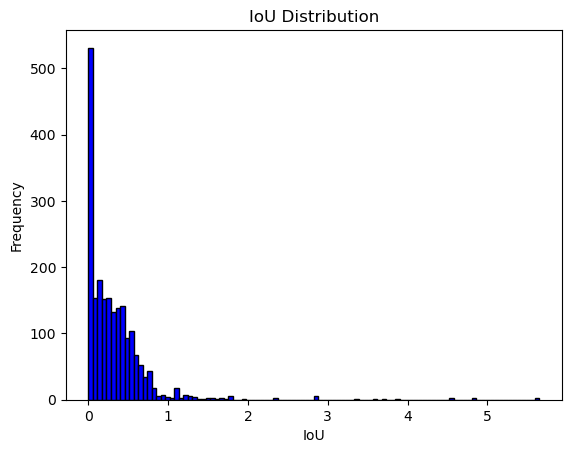

In [90]:
plt.hist(results_df["MAPE metric"], bins=100, color='blue', edgecolor='black')
plt.xlabel("IoU")
plt.ylabel("Frequency")
plt.title("IoU Distribution")
plt.show()


Statistics for Ford:
Mean Emission: 158.04883202000002
Median Emission: 163.39234665
Standard Deviation: 18.07425370354377

Statistics for Chevrolet:
Mean Emission: 192.35849489999998
Median Emission: 190.6631579
Standard Deviation: 42.9321134197241

Statistics for Audi:
Mean Emission: 215.36333803333332
Median Emission: 153.5335689
Standard Deviation: 80.3086290898333

Statistics for BMW:
Mean Emission: 172.38617908333333
Median Emission: 169.8167539
Standard Deviation: 6.617368132333963

Statistics for Hyundai:
Mean Emission: 136.5384615
Median Emission: 136.5384615
Standard Deviation: 0.0

Statistics for Dodge:
Mean Emission: 222.35185184000002
Median Emission: 225.0
Standard Deviation: 14.946647218354983

Statistics for Aston Martin:
Mean Emission: 339.25
Median Emission: 339.25
Standard Deviation: 0.0

Statistics for Volvo:
Mean Emission: 232.17991633333335
Median Emission: 212.539749
Standard Deviation: 109.33115809164833

Statistics for Chrysler:
Mean Emission: 233.25
Median Em

/var/folders/b7/sh1wg8qs3653z_965c8z6_980000gn/T/ipykernel_83578/2259292213.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  models_df_top_brands['Average emission of CO2'] = models_df_top_brands['Average emission of CO2'].str.replace(',', '.').astype(float)


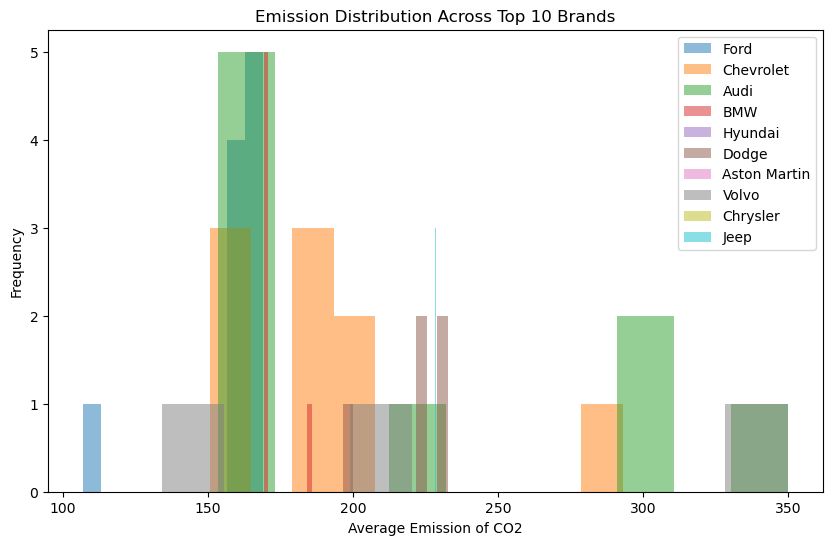

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the DataFrame
models_df = pd.read_csv("carbon_footprint/models_consumption.csv")

# Step 1: Identify the 10 most represented brands
top_brands = models_df['Brand'].value_counts().nlargest(10).index

# Step 2: Create a subset of the DataFrame for the top 10 brands
models_df_top_brands = models_df[models_df['Brand'].isin(top_brands)]

# Step 3: Clean the "Average emission of CO2" column
models_df_top_brands['Average emission of CO2'] = models_df_top_brands['Average emission of CO2'].str.replace(',', '.').astype(float)

# Step 4: Analyze Emission Distribution
for brand in top_brands:
    brand_data = models_df_top_brands[models_df_top_brands['Brand'] == brand]['Average emission of CO2']
    
    # Calculate statistics
    mean_emission = brand_data.mean()
    median_emission = brand_data.median()
    std_dev_emission = brand_data.std()
    
    print(f"\nStatistics for {brand}:\n"
          f"Mean Emission: {mean_emission}\n"
          f"Median Emission: {median_emission}\n"
          f"Standard Deviation: {std_dev_emission}")

# Step 5: Visualize the Data
plt.figure(figsize=(10, 6))
for brand in top_brands:
    plt.hist(models_df_top_brands[models_df_top_brands['Brand'] == brand]['Average emission of CO2'], alpha=0.5, label=brand)

plt.title('Emission Distribution Across Top 10 Brands')
plt.xlabel('Average Emission of CO2')
plt.ylabel('Frequency')
plt.legend()
plt.show()


Let's try better embeddings

In [65]:
models_df = pd.read_csv("carbon_footprint/models_consumption.csv")
model_to_label = {model: idx for idx, model in enumerate(models_df['full name'])}
print(model_to_label)
len(model_to_label)

{'Ford Fiesta Sedan 2012': 0, 'FIAT 500 Convertible 2012': 1, 'Chevrolet Corvette ZR1 2012': 2, 'Lamborghini Gallardo LP 570-4 Superleggera 2012': 3, 'Honda Accord Coupe 2012': 4, 'Volvo C30 Hatchback 2012': 5, 'BMW 1 Series Convertible 2012': 6, 'Lamborghini Aventador Coupe 2012': 7, 'Suzuki SX4 Sedan 2012': 8, 'Hyundai Genesis Sedan 2012': 9, 'Chevrolet Silverado 1500 Extended Cab 2012': 10, 'Ford F-150 Regular Cab 2007': 11, 'Hyundai Azera Sedan 2012': 12, 'Chrysler Crossfire Convertible 2008': 13, 'Lamborghini Reventon Coupe 2008': 14, 'Hyundai Veracruz SUV 2012': 15, 'Suzuki Aerio Sedan 2007': 16, 'Ford F-450 Super Duty Crew Cab 2012': 17, 'Chrysler PT Cruiser Convertible 2008': 18, 'Ford Ranger SuperCab 2011': 19, 'Volkswagen Beetle Hatchback 2012': 20, 'Infiniti G Coupe IPL 2012': 21, 'Hyundai Sonata Hybrid Sedan 2012': 22, 'Jeep Wrangler SUV 2012': 23, 'Chevrolet TrailBlazer SS 2009': 24, 'Dodge Durango SUV 2007': 25, 'Volvo XC90 SUV 2007': 26, 'Ford Mustang Convertible 2007': 

100

In [62]:
class CarDataset(Dataset):
    def __init__(self, root_dir="datasets_train/", annotations_file="datasets_train/train_annotation/_annotation.csv"):
        """
        Initialize the custom dataset.

        Args:
            root_dir (str): Path to the data folder.
            annotations_file (str): Path to the CSV file with image annotations.
            label_dict (dict): Mapping of class labels to integers.
            transforms (Bool, optional): To apply if training.
        """
        self.root_dir = os.path.join(os.getcwd(), root_dir)  
 
        self.data = pd.read_csv(annotations_file).dropna()
        self.transforms = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Resize((256,256)),
                torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ]) # To be adjusted

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, "train",self.data.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        model_str = self.data.iloc[idx, 6]
        model_label = model_to_label[model_str]

        return self.transforms(image), model_label

In [63]:
dataset = CarDataset()
train_loader = torch.utils.data.DataLoader(dataset,
        batch_size=32,
        shuffle=True, drop_last=True)

In [67]:

import torch.nn as nn# Example of fine-tuning the model

num_classes = 100
model = resnet50(pretrained=True)
# Modify the last layer
model.fc = nn.Linear(model.fc.in_features, num_classes)
# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Fine-tune the model
num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    losses = []
    for inputs, labels in tqdm(train_loader, total=len(train_loader)):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Loss : {np.mean(losses):3f}")



/Users/timotheschmidt/miniconda3/envs/ml/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/timotheschmidt/miniconda3/envs/ml/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/10 [00:00<?, ?it/s]/Users/timotheschmidt/miniconda3/envs/ml/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17,

KeyboardInterrupt: 

In [ ]:
def plot_latent_vae(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))[0]
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10', s=1)
        if i > num_batches:
            plt.colorbar()
            break

In [92]:
# Load the dataset of car images
car_images_path = 'datasets_train/train'

# Path to the reference photos directory
reference_photos_path = 'carbon_footprint/car_models'

# Path to the new samples for each reference model
new_reference_photos_path = 'carbon_footprint/Modèles'

# Load reference photos and extract features
reference_features = []
reference_labels = []

# Load features from the original reference photos
with torch.no_grad():
    ref_img_folder = [f for f in os.listdir(reference_photos_path) if f.endswith("jpg")]
    for ref_img_file in ref_img_folder:
        ref_img_path = os.path.join(reference_photos_path, ref_img_file)
        image = preprocess(Image.open(ref_img_path).convert('RGB')).unsqueeze(0)
        features = model(image)
        features = features.squeeze().detach().numpy()
        reference_features.append(features)
        reference_labels.append(ref_img_file)

# Load features from the new samples
modele_folder = [f for f in os.listdir(new_reference_photos_path) if os.path.isdir(os.path.join(new_reference_photos_path, f))]
for model_folder in modele_folder:
    model_path = os.path.join(new_reference_photos_path, model_folder)
    model_img_folder = [f for f in os.listdir(model_path) if f.endswith("jpg")]
    for model_img_file in model_img_folder:
        img_path = os.path.join(model_path, model_img_file)
        image = preprocess(Image.open(img_path).convert('RGB')).unsqueeze(0)
        features = model(image)
        features = features.squeeze().detach().numpy()
        reference_features.append(features)
        reference_labels.append(model_folder)

# Create an index for nearest neighbor search
reference_features = np.vstack(reference_features)
knn = NearestNeighbors(n_neighbors=1, metric='euclidean')
knn.fit(reference_features)

# Load the dataset of car images
car_image_folder = [f for f in os.listdir(car_images_path) if f.endswith("jpg")]



for index, train_row in train_df.iterrows():
    car_img_path = os.path.join(car_images_path, train_row['im_name'])
    car_img = preprocess(Image.open(car_img_path).convert('RGB')).unsqueeze(0)
    features = model(car_img)
    features = features.squeeze().detach().numpy()  # Convert to a 1D NumPy array
    
    # Find the nearest neighbor in the reference photos
    _, nearest_neighbor_idx = knn.kneighbors([features], n_neighbors=1)
    nearest_neighbor_label = reference_labels[nearest_neighbor_idx[0][0]].split('.')[0]
    
    
    # Use the nearest neighbor's label to estimate CO2 emissions
    pred_row = true_df[true_df["full name"] == nearest_neighbor_label].iloc[0]
    pred_co2_emission = float(pred_row['Average emission of CO2'].replace(',', '.'))
    # get the true emission
    true_model = train_row['models']
    print(f"predicted model : {nearest_neighbor_label}")
    print(f"true model : {true_model}")
    true_row = true_df[true_df["full name"] == true_model].iloc[0]
    
    true_co2_emission = float(true_row['Average emission of CO2'].replace(',', '.'))
    mape = local_MAPE(true_co2_emission, pred_co2_emission)
    new_row = {
        'im_name': train_row['im_name'],
        'model': true_model, 
        'predicted emission': pred_co2_emission, 
        'true emission': true_co2_emission, 
        'MAPE metric': mape,

    }

    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)


predicted model : Dodge Caliber Wagon 2007
true model : Toyota Sequoia SUV 2012
predicted model : Dodge Charger Sedan 2012
true model : Toyota Sequoia SUV 2012
predicted model : Dodge Charger Sedan 2012
true model : Toyota Sequoia SUV 2012
predicted model : Cadillac SRX SUV 2012
true model : Toyota Sequoia SUV 2012
predicted model : Dodge Durango SUV 2007
true model : Toyota Sequoia SUV 2012
predicted model : Dodge Charger Sedan 2012
true model : Toyota Sequoia SUV 2012
predicted model : Acura ZDX Hatchback 2012
true model : Toyota Sequoia SUV 2012
predicted model : Cadillac SRX SUV 2012
true model : Toyota Sequoia SUV 2012
predicted model : Honda Odyssey Minivan 2012
true model : Toyota Sequoia SUV 2012
predicted model : Cadillac SRX SUV 2012
true model : Toyota Sequoia SUV 2012
predicted model : Cadillac SRX SUV 2012
true model : Toyota Sequoia SUV 2012
predicted model : BMW M5 Sedan 2010
true model : Toyota Sequoia SUV 2012
predicted model : Mitsubishi Lancer Sedan 2012
true model :

In [93]:
results_df

,im_name,model,predicted emission,true emission,MAPE metric
0,1000407040.jpg,Toyota Sequoia SUV 2012,300.000000,129.142857,1.323009
1,1000472576.jpg,Toyota Sequoia SUV 2012,232.629630,129.142857,0.801336
2,1000669184.jpg,Toyota Sequoia SUV 2012,129.142857,129.142857,0.000000
3,1000800256.jpg,Toyota Sequoia SUV 2012,232.629630,129.142857,0.801336
4,1001324544.jpg,Toyota Sequoia SUV 2012,232.629630,129.142857,0.801336
...,...,...,...,...,...
4173,993853440.jpg,Suzuki SX4 Sedan 2012,150.615385,139.000000,0.083564
4174,994246656.jpg,Suzuki SX4 Sedan 2012,169.816754,139.000000,0.221703
4175,999489536.jpg,Toyota Sequoia SUV 2012,300.000000,129.142857,1.323009
4176,999686144.jpg,Toyota Sequoia SUV 2012,129.142857,129.142857,0.000000


In [94]:
results_df["MAPE metric"].describe()

count    4178.000000
mean        0.347002
std         0.530836
min         0.000000
25%         0.054165
50%         0.240720
75%         0.458626
max         7.638344
Name: MAPE metric, dtype: float64

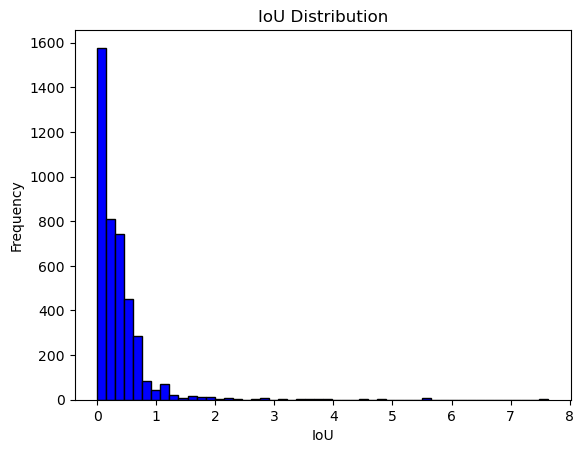

In [95]:
plt.hist(results_df["MAPE metric"], bins=50, color='blue', edgecolor='black')
plt.xlabel("IoU")
plt.ylabel("Frequency")
plt.title("IoU Distribution")
plt.show()